# Reverse Game of Life - Z3 Constraint Satisfaction

[Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is an example of 2D cellular automata. 

I have previously written an interactive playable demo of the forward version of this game:
- https://life.jamesmcguigan.com/

Using the classic ruleset on a 25x25 board with wraparound, the game evolves at each timestep according to the following rules
- Overpopulation: if a living cell is surrounded by more than three living cells, it dies.
- Stasis: if a living cell is surrounded by two or three living cells, it survives.
- Underpopulation: if a living cell is surrounded by fewer than two living cells, it dies.
- Reproduction: if a dead cell is surrounded by exactly three cells, it becomes a live cell.

Or expressed algebraicly:
- living + 4-8 neighbours = dies
- living + 2-3 neighbours = lives
- living + 0-1 neighbour  = dies
- dead   +   3 neighbours = lives


To reverse the arrow of time:
- any living cell must have had living 2-3 neighbours in the previous timestep
- any dead cell must have had either 0-1 or 4-8 neighbours in the previous timestep
- any dead cell with distance of greater than 2 from a living cell can be ignored and assumed to have 0 neighbours
  - there are a near infinite number of self-contained patterns could have been born and died out in empty space
  - however for the sake of the competition, ignoring them will greatly reduce the search space


Whilst there have been many proposed solutions involving CNN neural networks (when all you have is a hammer, everything looks like a nail), this is in fact a classic constraint satisfaction problem. Here are some previous examples of using the Z3 library 
- https://www.kaggle.com/jamesmcguigan/z3-sudoku-solver
- https://www.kaggle.com/jamesmcguigan/cryptarithmetic-solver

# Utility Functions

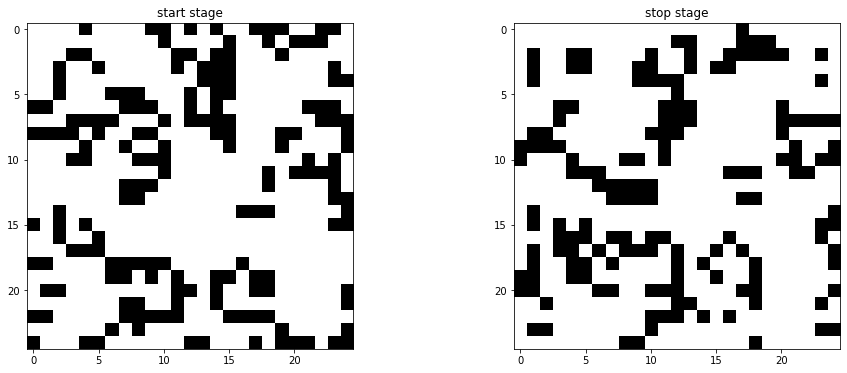

In [1]:
from plot import plot_fig, plot_xy, plot_animate_fig, life_step
from util import csv_to_delta, csv_to_numpy, numpy_to_dict
from datasets import train_df, test_df
from z3_solver import solve_dataframe

plot_fig(train_df, 1)

# Z3 Solver

Here we define a Z3 solver, with a 3d (= 2d + time) grid of t_cells, representing the current board state and previous timesteps for the required delta to be solved.

As we are going backwards, we can ignore the rules for dead cells, and simply define the constraints required for the past timestep to produce living cells in the current timestep. We also define a rule to ignore any cells that currently have 0 neighbours to reduce the search space and prevent zero-point energy solutions.

In [2]:
import z3
from z3_solver import reverse_game_of_life_solver, reverse_game_of_life_next_solution
from z3_solver import solver_to_numpy

# Visualization of Solutions   

Here we show all possible solutions that could possibly solve the first datapoint 

In [ ]:
idx      = 0      # delta = 3 - solved
# idx      = 4      # delta = 1 - unsolvable
# idx      = 49999  # delta = 2 - unsolvable
delta    = csv_to_delta(train_df, idx)
board    = csv_to_numpy(train_df, idx, type='stop')
expected = csv_to_numpy(train_df, idx, type='start')

plot_xy(expected, board, title1 = 'T=0 expected', title2 = f'T={delta}')

z3_solver, t_cells = reverse_game_of_life_solver(board, delta)  # takes ~10s
solution = solver_to_numpy(z3_solver, t_cells)
plot_xy(solution, board, title1 = 'T=0 solved', title2 = f'T={delta}')
# plot_animate_fig(solution, board, delta)

How many solutions are there in total?

In [ ]:
solution_count = 1
while z3_solver.check() == z3.sat: 
    plot_xy(board, solver_to_numpy(z3_solver, t_cells), title1 = f'T={delta}', title2 = 'T=0 solved')
    z3_solver, t_cells = reverse_game_of_life_next_solution(z3_solver, t_cells) # takes ~0.5s per solution
    solution_count += 1
    if solution_count > 10: break
print(f'Total Solutions: {solution_count}')

# Training Dataset

In [ ]:
solve_dataframe(train_df).to_csv('train.csv')

In [ ]:
# Submission
